# Time Series For beginners with ARIMA

## Table of contents
2. [Import Libraries](#Import-Libraries)
3. [Read Data](#read-data)
4. [Data Transformation to achieve Stationarity](#data-transform)
    1. [Log Scale Transformation](#log)
    2. [Exponential Decay Transformation](#exp)
    3. [Time Shift Transformation](#shift)    
5. [Plotting ACF & PACF](#acf-pacf)
6. [Building Models](#model)
7. [Prediction & Reverse transformations](#prediction)


## Import Libraries <a name="Import-Libraries"></a>

In [1]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Read Data  <a name="read-data"></a>
Time series deals with 2 columns, one is temporal ie: month in this case & another is the value to be forecasted ie: airplane passengers. To make plotting graphs easier, we set the index of pandas dataframe to the Month. During plots, the index will act by default as the x-axis & since it has only 1 more column, that will be automatically taken as the y-axis

In [2]:
#path = "input/AirPassengers.csv" #For local
# path = "../input/AirPassengers.csv" #For Kaggle
path = "/kaggle/input/alpha-vantage-stock-symbols/combined_featured_stocks_daily_data.csv" #For Kaggle
df = pd.read_csv(path)
#Parse strings to datetime type
# dataset['Close'] = pd.to_datetime(dataset['Close'],infer_datetime_format=True) #convert from string to datetime


indexedDataset = df[df['Symbol'] == 'AAPL'][['Timestamp', 'Close']]
indexedDataset['Timestamp'] = pd.to_datetime(indexedDataset['Timestamp'])
indexedDataset = indexedDataset.set_index(['Timestamp'])
indexedDataset.head(5)

,Close
Timestamp,
1999-11-01,77.62
1999-11-02,80.25
1999-11-03,81.50
1999-11-04,83.62
1999-11-05,88.31


From the plot below, we can see that there is a Trend compoenent in th series. Hence, we now check for stationarity of the data

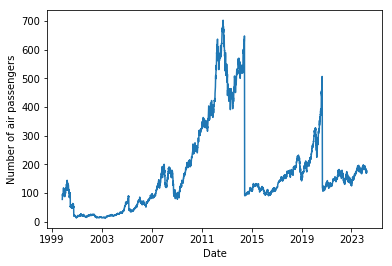

In [3]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexedDataset)

In [4]:
#Determine rolling statistics
rolmean = indexedDataset.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean,rolstd)

                 Close
Timestamp             
1999-11-01         NaN
1999-11-02         NaN
1999-11-03         NaN
1999-11-04         NaN
1999-11-05         NaN
1999-11-08         NaN
1999-11-09         NaN
1999-11-10         NaN
1999-11-11         NaN
1999-11-12         NaN
1999-11-15         NaN
1999-11-16   87.685833
1999-11-17   88.738333
1999-11-18   89.519167
1999-11-19   90.430833
1999-11-22   91.014167
1999-11-23   91.389167
1999-11-24   91.249167
1999-11-26   91.702500
1999-11-29   91.962500
1999-11-30   92.430833
1999-12-01   93.467500
1999-12-02   95.196667
1999-12-03   97.180833
1999-12-06   99.326667
1999-12-07  101.675833
1999-12-08  103.144167
1999-12-09  104.363333
1999-12-10  105.212500
1999-12-13  105.571667
...                ...
2024-02-08  189.390000
2024-02-09  188.919167
2024-02-12  188.334167
2024-02-13  187.719167
2024-02-14  187.087500
2024-02-15  186.739167
2024-02-16  186.565000
2024-02-20  186.123333
2024-02-21  185.829167
2024-02-22  185.553333
2024-02-23 

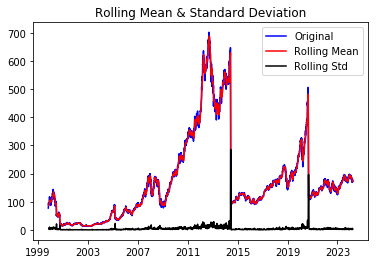

In [5]:
#Plot rolling statistics
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

From the above graph, we see that rolling mean itself has a trend component even though rolling standard deviation is fairly constant with time. For our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so. 

To further augment our hypothesis that the time series is not stationary, let us perform the ADCF test.

In [6]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['Close'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -2.557764
p-value                           0.102044
#Lags Used                        0.000000
Number of Observations Used    6135.000000
Critical Value (1%)              -3.431416
Critical Value (5%)              -2.862011
Critical Value (10%)             -2.567021
dtype: float64


For a Time series to be stationary, its ADCF test should have:
1. p-value to be low (according to the null hypothesis)
2. The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics

From the above ADCF test result, we see that p-value(at max can be 1.0) is very large. Also critical values are no where close to the Test Statistics. Hence, we can safely say that **our Time Series at the moment is not stationary**

## Data Transformation to achieve Stationarity <a name="data-transform"></a>

There are a couple of ways to achieve stationarity through data transformation like taking $log_{10}$,$log_{e}$, square, square root, cube, cube root, exponential decay, time shift and so on ...

In our notebook, lets start of with log transformations. Our objective is to remove the trend component. Hence,  flatter curves( ie: paralle to x-axis) for time series and rolling mean after taking log would say that our data transformation did a good job.

### Log Scale Transformation  <a name="log"></a>

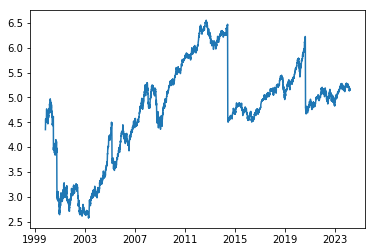

In [7]:
#Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

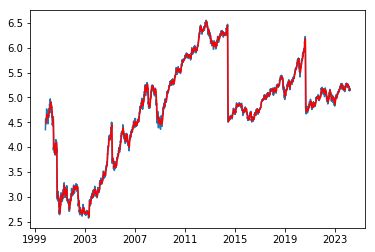

In [8]:
#The below transformation is required to make series stationary
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

From above graph, we see that even though rolling mean is not stationary, it is still better than the previous case, where no transfromation were applied to series. So we can atleast say that we are heading in the right direction.

We know from above graph that both the Time series with log scale as well as its moving average have a trend component. Thus we can apply a elementary intuition: subtraction one from the other should remove the trend component of both. Its like:  

$log scale L = stationary part(L1) + trend(LT)$   
$moving avg of log scale A = stationary part(A1) + trend(AT)$   
$result series R = L - A = (L1+LT) - (A1+AT) = (L1-A1) + (LT-AT)$

Since, L & A are series & it moving avg, their trend will be more or less same, Hence  
LT-AT nearly equals to 0  

Thus trend component will be almost removed. And we have,  
  
$R = L1 - A1$, our final non-trend curve

In [9]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Close
Timestamp,
1999-11-16,0.041124
1999-11-17,0.018199
1999-11-18,0.001991
1999-11-19,0.022476
1999-11-22,-0.004108
1999-11-23,0.015630
1999-11-24,0.037149
1999-11-26,0.036138
1999-11-29,0.028068


In [10]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Close'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

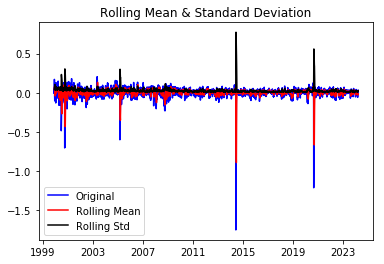

Results of Dickey Fuller Test:
Test Statistic                -1.725339e+01
p-value                        6.003792e-30
#Lags Used                     1.300000e+01
Number of Observations Used    6.111000e+03
Critical Value (1%)           -3.431421e+00
Critical Value (5%)           -2.862013e+00
Critical Value (10%)          -2.567022e+00
dtype: float64


In [11]:
test_stationarity(datasetLogScaleMinusMovingAverage)

From above graph, we observe that our intuition that *"subtracting two related series having similar trend components will make the result stationary"* is true. We find that:  

1. p-value has reduced from 0.99 to 0.022.  
2. The critical values at 1%,5%,10% confidence intervals are pretty close to the Test Statistic.
Thus, from above 2 points, we can say that our given series is stationary.  

But, in the spirit of getting higher accuracy, let us explore & try to find a better scale than our current log.

Let us try out Exponential decay.  
For further info, refer to my answer 12 at the top of the notebook on it.

### Exponential Decay Transformation   <a name="exp"></a>

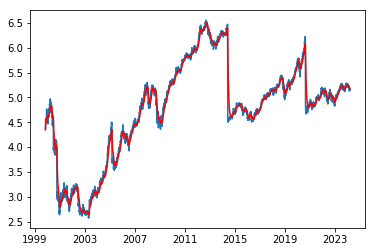

In [12]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

From above graph, it seems that exponential decay is not holding any advantage over log scale as both the corresponding curves are similar. But, in statistics, inferences cannot be drawn simply by looking at the curves. Hence, we perform the ADCF test again on the decay series below.

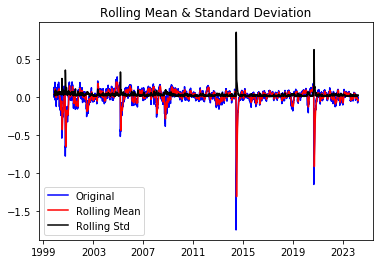

Results of Dickey Fuller Test:
Test Statistic                -1.288510e+01
p-value                        4.571799e-24
#Lags Used                     1.000000e+00
Number of Observations Used    6.134000e+03
Critical Value (1%)           -3.431417e+00
Critical Value (5%)           -2.862011e+00
Critical Value (10%)          -2.567021e+00
dtype: float64


In [13]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

We observe that the Time Series is stationary & also the series for moving avg & std. dev. is almost parallel to x-axis thus they also have no trend.  
Also,     
1. p-value has decreased from 0.022 to 0.005.  
2. Test Statistic value is very much closer to the Critical values.  
Both the points say that our current transformation is better than the previous logarithmic transformation. Even though, we couldn't observe any differences by visually looking at the graphs, the tests confirmed decay to be much better.

But lets try one more time & find if an even better solution exists. We will try out the simple time shift technique, which is simply:  

Given a set of observation on the time series:  
$ x0, x1, x2, x3, .... xn $  

The shifted values will be:    
$ null, x0, x1, x2,.... xn $                             <---- basically all xi's shifted by 1 pos to right  

Thus, the time series with time shifted values are:   
$ null, (x1-x0), (x2-x1), (x3-x2), (x4-x3),.... (xn-x_{n-1}) $   

### Time Shift Transformation  <a name="shift"></a>

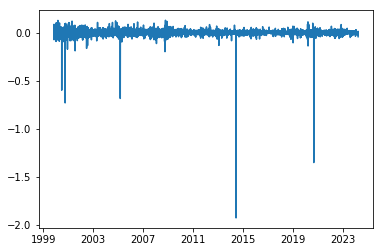

In [14]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

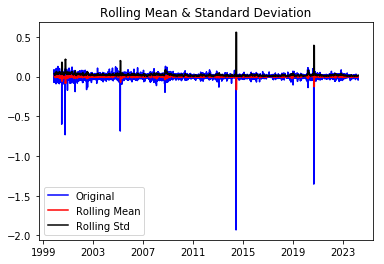

Results of Dickey Fuller Test:
Test Statistic                  -79.920686
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    6134.000000
Critical Value (1%)              -3.431417
Critical Value (5%)              -2.862011
Critical Value (10%)             -2.567021
dtype: float64


In [15]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

From above 2 graphs, we can see that, visually this is the best result as our series along with rolling statistic values of moving avg & moving std. dev. is very much flat & stationary. But, the ADCF test shows us that:
1. p-value of 0.07 is not as good as 0.005 of exponential decay.  
2. Test Statistic value not as close to the critical values as that for exponential decay.  
  
We have thus tried out 3 different transformation: log, exp decay & time shift. For simplicity, we will go with the log scale. The reason for doing this is that we can revert back to the original scale during forecasting.

Let us now break down the 3 components of the log scale series using a system libary function. Once, we separate our the components, we can simply ignore trend & seasonality and check on the nature of the residual part.

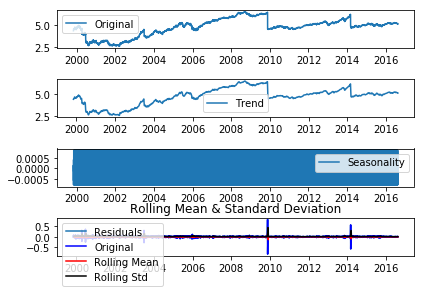

Results of Dickey Fuller Test:
Test Statistic                  -22.327132
p-value                           0.000000
#Lags Used                       34.000000
Number of Observations Used    6095.000000
Critical Value (1%)              -3.431423
Critical Value (5%)              -2.862014
Critical Value (10%)             -2.567022
dtype: float64


In [16]:
indexedDataset_logScale.index = pd.date_range(start=indexedDataset_logScale.index[0],
                                              periods=len(indexedDataset_logScale), 
                                              freq='D')

decomposition = seasonal_decompose(indexedDataset_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

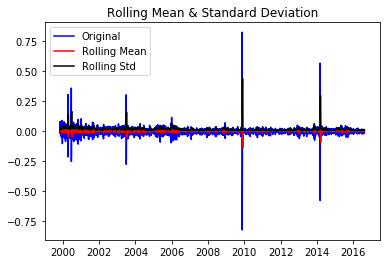

Results of Dickey Fuller Test:
Test Statistic                  -22.327132
p-value                           0.000000
#Lags Used                       34.000000
Number of Observations Used    6095.000000
Critical Value (1%)              -3.431423
Critical Value (5%)              -2.862014
Critical Value (10%)             -2.567022
dtype: float64


In [17]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

## Plotting ACF & PACF <a name="acf-pacf"></a>

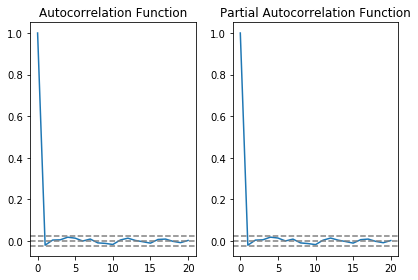

In [18]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

From the ACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, Q = 2
From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS. Lower RSS values indicate a better model.

## Building Models <a name="model"></a>

/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

Plotting AR model


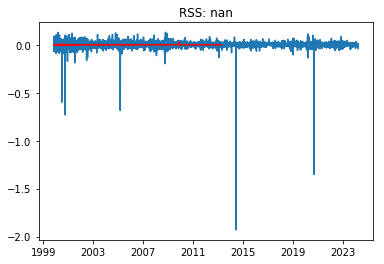

In [19]:
#AR Model
#making order=(2,1,0) gives RSS=1.5023
split_point = int(len(indexedDataset_logScale) * 0.8)
train_data, test_data = indexedDataset_logScale.iloc[:split_point], indexedDataset_logScale.iloc[split_point:]
model = ARIMA(train_data, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Close'])**2))
print('Plotting AR model')

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Plotting MA model


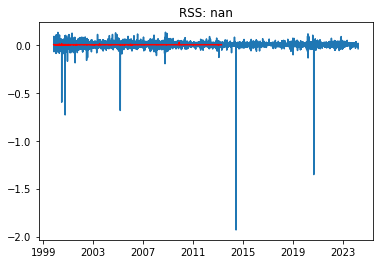

In [20]:
#MA Model
model = ARIMA(train_data, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['Close'])**2))
print('Plotting MA model')

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Converg

Plotting ARIMA model


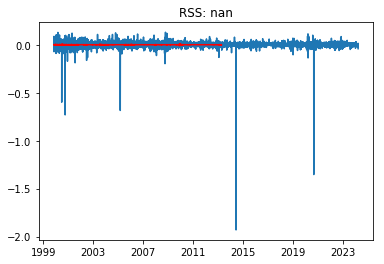

In [21]:
# AR+I+MA = ARIMA model
model = ARIMA(train_data, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['Close'])**2))
print('Plotting ARIMA model')

By combining AR & MA into ARIMA, we see that RSS value has decreased from either case to 1.0292, indicating ARIMA to be better than its individual component models.   

With the ARIMA model built, we will now generate predictions. But, before we do any plots for predictions ,we need to reconvert the predictions back to original form. This is because, our model was built on log transformed data.

## Prediction & Reverse transformations <a name="prediction"></a>

In [22]:
forecast_steps = len(test_data)
predictions_ARIMA_diff = results_ARIMA.forecast(steps=forecast_steps)[0]

In [23]:
# predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
# print(predictions_ARIMA_diff.head())

In [24]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

[5.34069857e+00 1.06809949e+01 1.60221105e+01 ... 6.69870295e+03
 6.70429036e+03 6.70987796e+03]


In [25]:
# predictions_ARIMA_log = pd.Series(indexedDataset_logScale['Close'].iloc[0], index=indexedDataset_logScale.index)
# predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
# predictions_ARIMA_log.head()

In [26]:
predictions_ARIMA_log = pd.Series(test_data['Close'].iloc[0], index=test_data.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

predictions_ARIMA_log.head()

2013-04-09    10.653215
2013-04-10    15.993511
2013-04-11    21.334627
2013-04-12    26.675369
2013-04-13    32.016896
Freq: D, dtype: float64

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


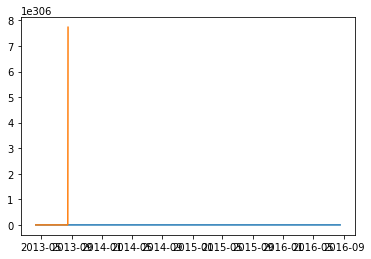

In [27]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(test_data)
plt.plot(predictions_ARIMA)

We see that our predicted forecasts are very close to the real time series values indicating a fairly accurate model.

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


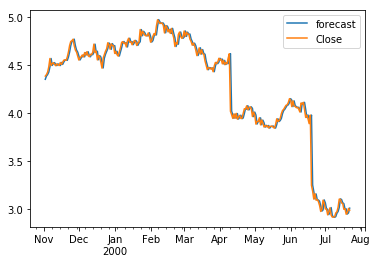

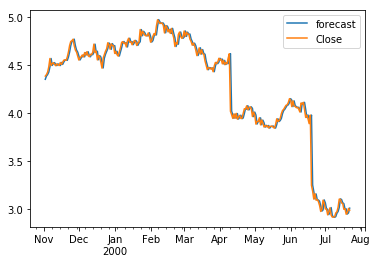

In [28]:
#We have 144(existing data of 12 yrs in months) data points. 
#And we want to forecast for additional 120 data points or 10 yrs.
results_ARIMA.plot_predict(1,264) 
#x=results_ARIMA.forecast(steps=120)

In [29]:
#print(x[1])
#print(len(x[1]))
#print(np.exp(x[1]))

## The End